In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
data_path = os.path.join('Datasets', 'WinequalityRed.csv')
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In this notebook I will try to predict **pH** using dataset.

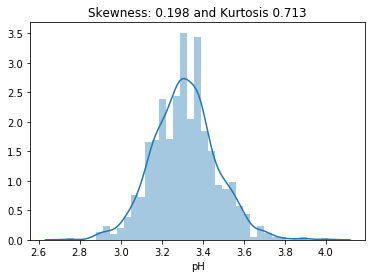

In [6]:
sns.distplot(train_df['pH'])
skewness = stats.skew(train_df['pH'])
kurtosis = stats.kurtosis(train_df['pH'])
plt.title(f'Skewness: {round(skewness, 3)} and Kurtosis {round(kurtosis, 3)}');

The distribution of pH is approximately normal. It is good so there is no need to transform targets.

Let's see correlation matrix. It a good starting point for features analysis.

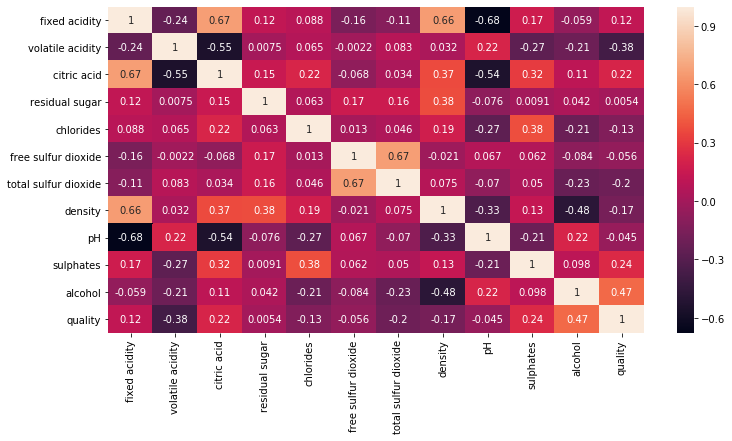

In [7]:
corr_mat = train_df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr_mat, annot=True)

There are a few variables strongly correlated with pH. Examples are fixed acidity (-0.68) and citric acid (-0.54). Unfortunately it can be not enough. Most of features seems not really important. However it is a common case when even not correlated features are good predictiors when are used together. That is why I will not delete any features.

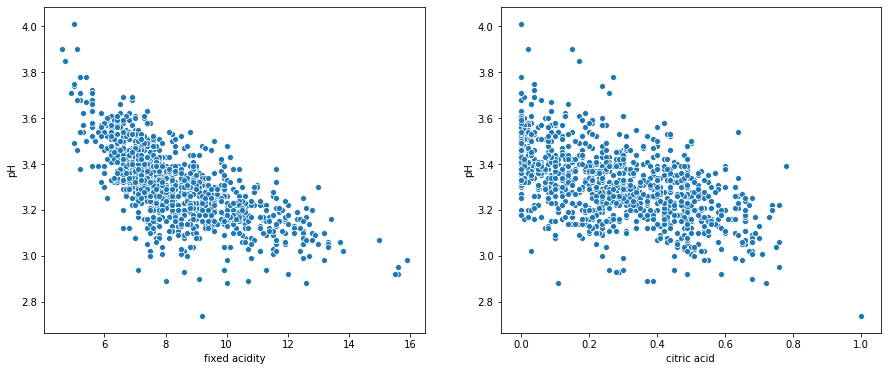

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x='fixed acidity', y='pH', data=train_df, ax=ax1)
sns.scatterplot(x='citric acid', y='pH', data=train_df, ax=ax2)

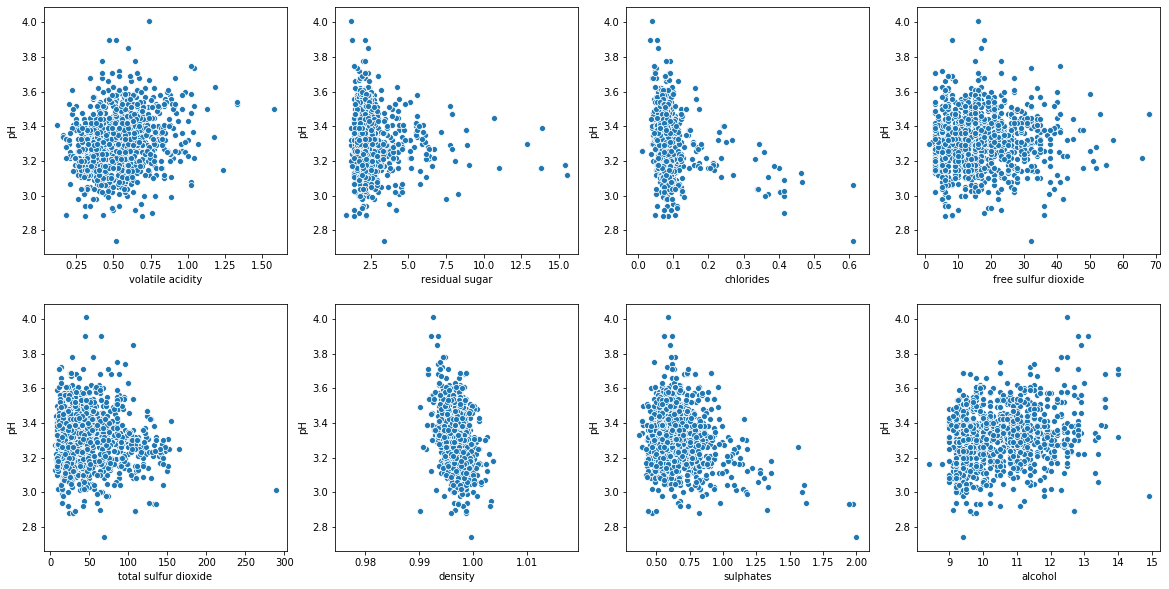

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
temp_df = train_df.drop(columns=['fixed acidity', 'citric acid', 'pH'])
for i, ax in enumerate(axes.flat):
    col = temp_df.columns[i]
    sns.scatterplot(x=col, y='pH', data=train_df, ax=ax)

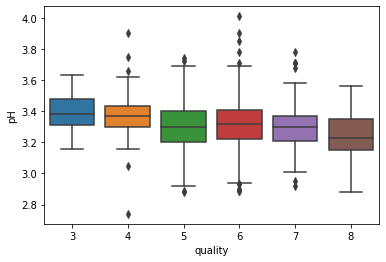

In [10]:
sns.boxplot(x='quality', y='pH', data=train_df)

### Machine learning

In [52]:
from itertools import cycle
from sklearn.linear_model import Ridge, LassoCV, lasso_path, enet_path
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score

Not useful columns

In [12]:
#cols_to_drop = ['volatile acidity', 'quality', 'citric acid']
#train_df = train_df.drop(columns=cols_to_drop)
#test_df = test_df.drop(columns=cols_to_drop)

In [13]:
X_train = train_df.drop(columns='pH')
Y_train = train_df['pH']

X_test = test_df.drop(columns='pH')
Y_test = test_df['pH']

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

**Lasso**

In [15]:
lasso = LassoCV(cv=10, random_state=42)
lasso.fit(X_train_scaled, Y_train)
lasso.score(X_test_scaled, Y_test)

0.7127325386412762

In [16]:
feat_df = pd.DataFrame({'feature_name': X_train_scaled.columns, 'importance': lasso.coef_})
corr_ph = train_df.corr()['pH']
feat_df = pd.merge(feat_df, corr_ph, left_on='feature_name', right_index=True, how='left')
feat_df.sort_values('importance', inplace=True, ascending=False,
                    key=lambda x: x.abs())
feat_df.rename(columns={'pH': 'correlation'}, inplace=True)
feat_df

,feature_name,importance,correlation
0,fixed acidity,-0.161229,-0.676197
7,density,0.114618,-0.332869
9,alcohol,0.075862,0.217202
3,residual sugar,-0.035300,-0.076215
6,total sulfur dioxide,-0.023917,-0.070382
4,chlorides,-0.022491,-0.268871
5,free sulfur dioxide,0.016055,0.066672
8,sulphates,-0.014383,-0.211560
2,citric acid,-0.006917,-0.540161
10,quality,-0.004880,-0.045185


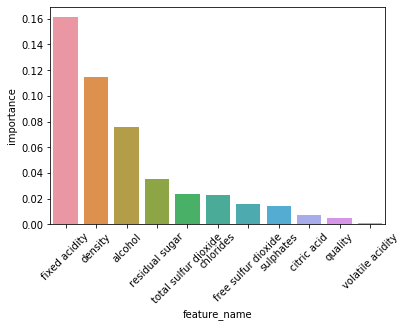

In [17]:
sns.barplot(x=feat_df['feature_name'], y=feat_df['importance'].abs())
plt.xticks(rotation = 45);

Text(0.5, 1.0, 'Lasso and Elastic Net paths')

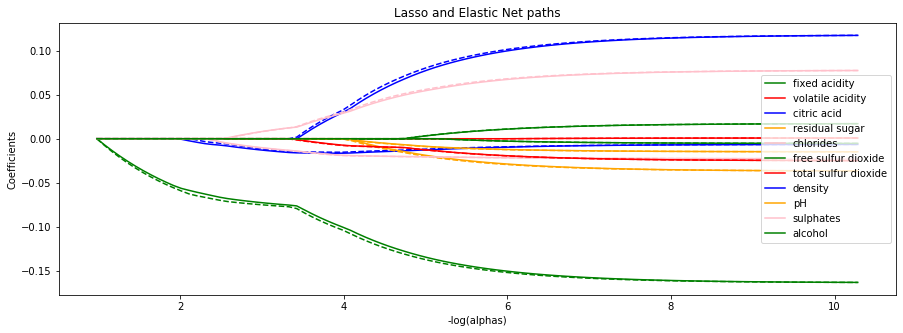

In [59]:
eps = 5e-4
lasso_alphas, lasso_coef, _ = lasso_path(X_train_scaled, Y_train, 
                                         eps=eps, fit_intercept=False)
enet_alphas, enet_coef, _ = enet_path(X_train_scaled, Y_train,
                                      eps=eps, fit_intercept=False)
lasso_log_alphas = -np.log10(alphas)
enet_log_alphas = -np.log10(alphas)
plt.figure(figsize=(15, 5))
colors = cycle(['green', 'red', 'blue', 'orange', 'pink'])
labels = train_df.columns
zip_params = zip(lasso_coef, enet_coef, colors, labels)
for lasso_c, enet_c, c, label in zip_params:
    plt.plot(lasso_log_alphas, enet_c, 
             c=c, label=label)
    plt.plot(enet_log_alphas, lasso_c, 
             linestyle='--', c=c)
plt.legend()   
plt.xlabel('-log(alphas)')
plt.ylabel('Coefficients')
plt.title('Lasso and Elastic Net paths')

### Polynomials

In [16]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)

In [17]:
lasso = LassoCV(cv=10, random_state=42)
lasso.fit(X_train_poly, Y_train)
lasso.score(X_test_poly, Y_test)

0.7546047686710488